## Overview
This notebook analyzes the Time-Frequency Representation (TFR) differences between trials that preivous one were successful and trials that previous one were unsuccessful. 


# Configuration 
help :
- condition (str): The condition to compare. Possible values are 'Stim_NoStim', 'Right_Left', 'BiasRight_BiasLeft', 
            'success_error', 'PrevSuccess_PrevFail', 'expected_unexpected_stim', 'Right_left_choice'.
- n_jobs (int): Number of jobs to run in parallel.
- region (str): Brain region of interest.
- tmin (float): Start time before event.
- tmax (float): End time after event.
- remove_first_trials_of_block (bool): Whether to remove the first trials of each block.
- overwrite (bool): Whether to overwrite existing files.
- min_trial (int): Minimum number of trials required for each condition.

In [1]:
params = {
    'condition': 'PrevSuccess_PrevFail',
    'n_jobs': 5,
    'region': 'VISam',
    'tmin': -0.6,
    'tmax': 0.1,
    'remove_first_trials_of_block': False,
    'overwrite': False,
    'min_trial': 50
}

In [2]:
# import libraries
import os
import numpy as np
import pandas as pd
import ast
import mne 
import sys
import submitit
import gc
import matplotlib.pyplot as plt
import re 

## get the probes id related to region of interest

In [3]:
region = params['region']
path_table_info = f'/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/extraction_module/data/eid_probe_info_{region}_{region}.csv'
table = pd.read_csv(path_table_info)
table['pid1'] = table['pid1'].apply(ast.literal_eval)
pids = []
eids = []
for i, row in enumerate(table.iterrows()):
    eid = row[1]['eid']
    pid1 = row[1]['pid1']
    for pid in pid1:
        if os.path.isfile(f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_raw.fif'):
            pids.append(pid)
            eids.append(eid)
print(f'Number of pids with files: {len(pids)} for region {region}')

Number of pids with files: 24 for region VISam


# submit jobs

In [4]:
from functions.TFR_difference import TFR_diff

joblist = []

executor = submitit.AutoExecutor(folder=os.getcwd()+'/logs/')
executor.update_parameters(mem_gb=16, timeout_min=300, slurm_partition="CPU", cpus_per_task=params['n_jobs'], slurm_comment='compute_epochTFR')

# Submit jobs
for i, (pid, eid) in enumerate(zip(pids, eids)):
    # if i >1:
    #     break
    job = executor.submit(TFR_diff, pid, eid, **params)
    job.job_initial_indice = i
    joblist.append(job)

# Monitor jobs
clean_jobs_live = False
finished_list, finished_order = [], []

print('#### Start waiting for jobs to return #####')
while joblist:
    for i, job in enumerate(joblist):
        if job.done():
            print(f"{len(finished_list)+1} on {len(joblist)}")
            print(f"last job finished: {job.job_id}")
            if clean_jobs_live:
                del job
                gc.collect()
            else:
                finished_list.append(job)
                finished_order.append(job.job_initial_indice)
            joblist.pop(i)
            break

print('#### All jobs completed #####')
print('#### you can start plotting the result #####')


#### Start waiting for jobs to return #####
1 on 24
last job finished: 38788
2 on 23
last job finished: 38787
3 on 22
last job finished: 38786
4 on 21
last job finished: 38783
5 on 20
last job finished: 38785
6 on 19
last job finished: 38789
7 on 18
last job finished: 38793
8 on 17
last job finished: 38794
9 on 16
last job finished: 38784
10 on 15
last job finished: 38806
11 on 14
last job finished: 38804
12 on 13
last job finished: 38791
13 on 12
last job finished: 38795
14 on 11
last job finished: 38792
15 on 10
last job finished: 38797
16 on 9
last job finished: 38802
17 on 8
last job finished: 38800
18 on 7
last job finished: 38790
19 on 6
last job finished: 38796
20 on 5
last job finished: 38803
21 on 4
last job finished: 38801
22 on 3
last job finished: 38805
23 on 2
last job finished: 38798
24 on 1
last job finished: 38799
#### All jobs completed #####
#### you can start plotting the result #####


In [5]:
unseccessful_jobs = []
sucessful_jobs = []
less_than_100 = []
for job in finished_list:
    if job.exception() is not None:
        unseccessful_jobs.append(job)
    else:
        sucessful_jobs.append(job)
for job in sucessful_jobs:
    if type(job.result()) == int:
        less_than_100.append(job)

        
print(f'Number of successful jobs: {len(sucessful_jobs)}')
print(f'Number of unseccessful jobs: {len(unseccessful_jobs)}')
print(f'Number of successful jobs with less than 100 epochs: {len(less_than_100)}')
for job in unseccessful_jobs:
    print(f'Unsuccessful job: {job.job_id} with error: {job.exception()}')

Number of successful jobs: 24
Number of unseccessful jobs: 0
Number of successful jobs with less than 100 epochs: 4


# Load and Plot the result

In [10]:
all_insersions = []
pids_to_plot = []
nb_channels = []
for pid in pids:
    condition = params['condition']
    path = f'/mnt/data/AdaptiveControl/IBLrawdata/TF_data/{region}/TFR_{condition}_{pid}.npy'
    if os.path.isfile(path):
        diff = np.load(path)
        nb_channel = diff.shape[0]
        diff_avg = np.mean(diff, axis=0, keepdims=False)
        all_insersions.append(diff_avg)
        pids_to_plot.append(pid)
        nb_channels.append(nb_channel)

all_insersions = np.array(all_insersions)
nb_subj = all_insersions.shape[0]   
print(all_insersions.shape)

(20, 53, 351)


## 1) grand average over all probes

I z-score normalized each session before averaging 

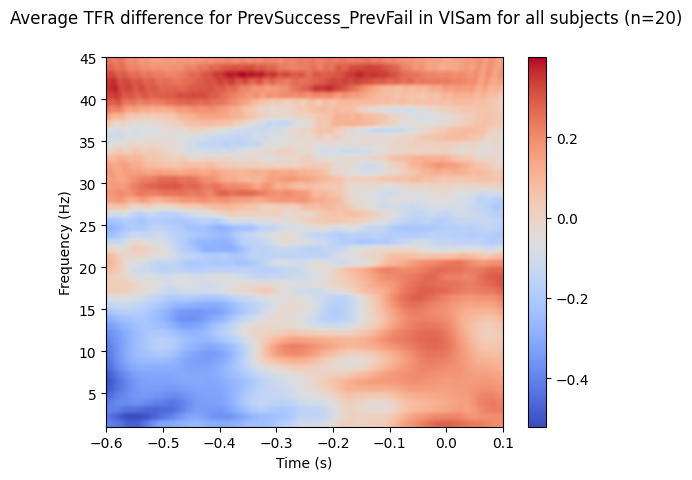

In [11]:
normalized_insersion = np.zeros_like(all_insersions)

# Z-score normalization for each subject
for i in range(all_insersions.shape[0]):
    mean = np.mean(all_insersions[i])
    std_dev = np.std(all_insersions[i])
    normalized_insersion[i] = (all_insersions[i] - mean) / std_dev

# Average over subjects after normalization
average_TF = np.mean(normalized_insersion, axis=0)
region = params['region']
tmin = params['tmin']
tmax = params['tmax']
fig, ax = plt.subplots()
fig.suptitle(f'Average TFR difference for {condition} in {region} for all subjects (n={nb_subj})')
ax.imshow(average_TF, aspect='auto', origin='lower', cmap='coolwarm', extent=[-0.6, 0, 1, 45])
fig.colorbar(ax.imshow(average_TF, aspect='auto', origin='lower', cmap='coolwarm', extent=[tmin, tmax, 1, 45]))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
plt.show()


## 2 ) TFR per insersion

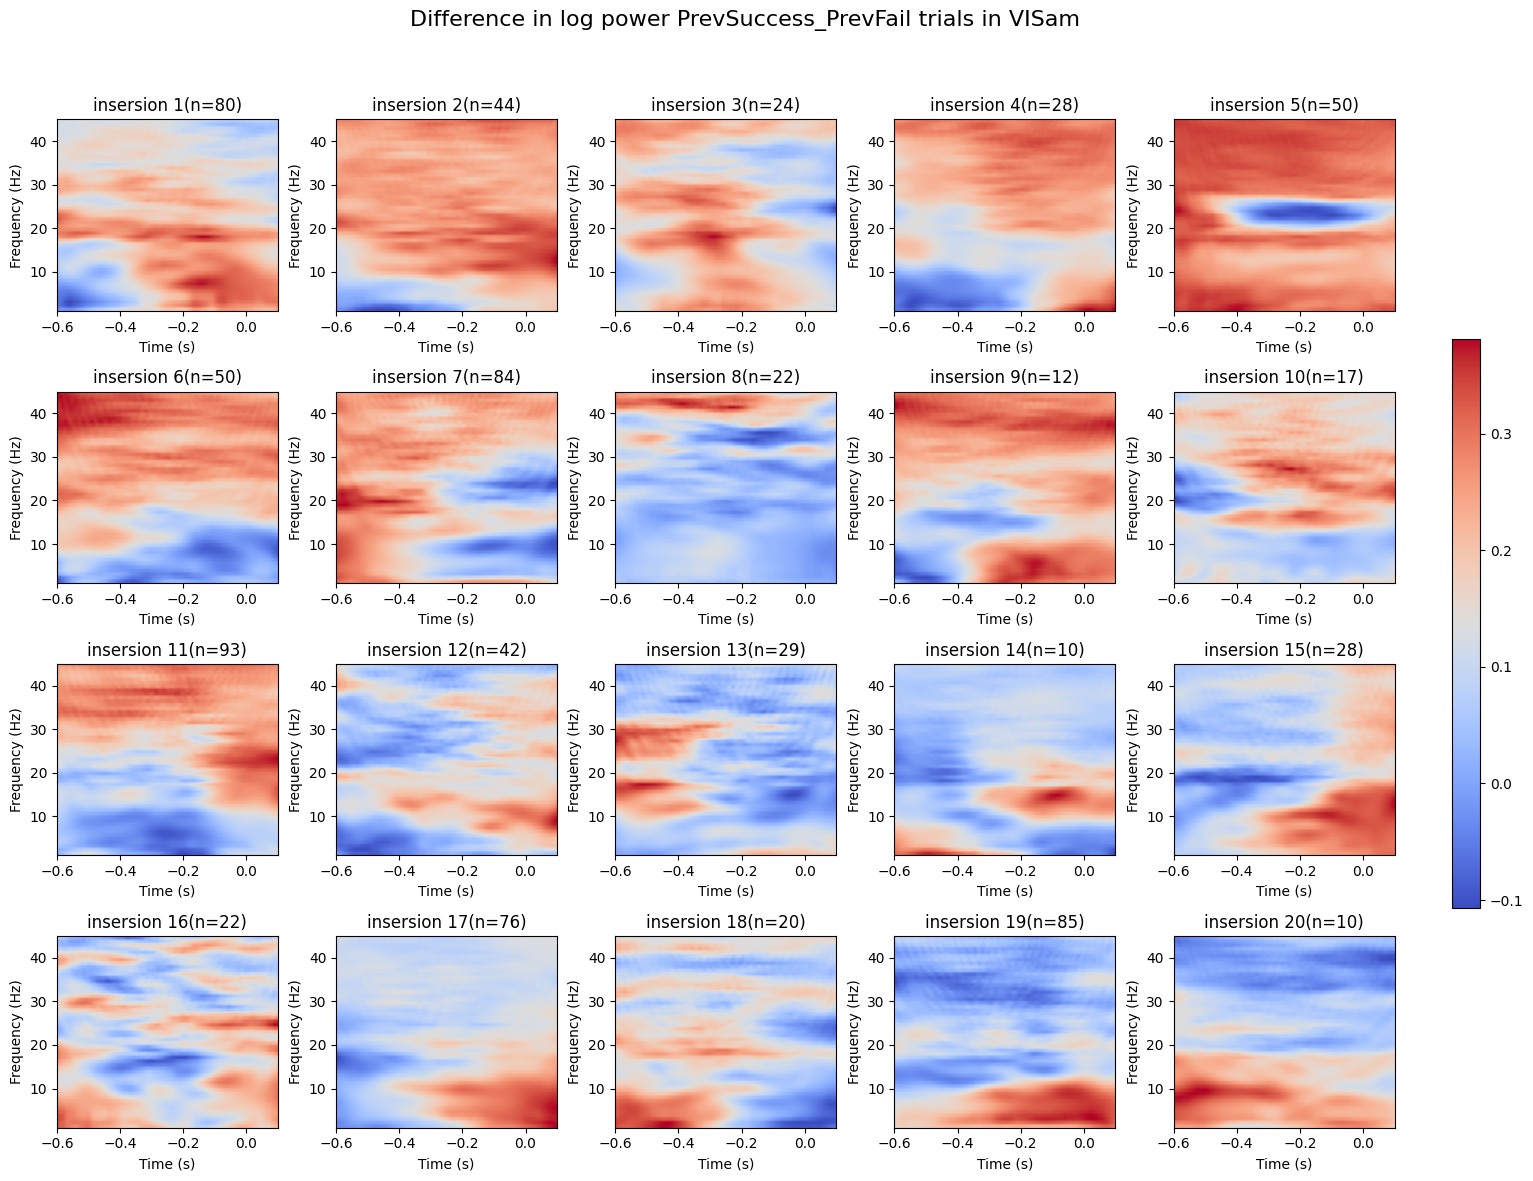

In [12]:
#  `all_insersions` is a 3D array with dimensions (nb_insersion, freqs, times)
insersion = all_insersions.shape[0]  # Number of insersions

# Set up a figure with 5 columns and enough rows to accommodate all channels
columns = 5
rows = int(np.ceil(insersion / columns))

fig, axes = plt.subplots(rows, columns, figsize=(15, rows * 3), 
                         sharex=False, sharey=False)
fig.suptitle(f'Difference in log power {condition} trials in {region}', fontsize=16)

# Flatten axes for easy iteration
axes = axes.flatten()

# Loop through each channel and plot the differences
for i, ax in enumerate(axes[:insersion]):
    im = ax.imshow(all_insersions[i], aspect='auto', origin='lower',
                   extent= [tmin, tmax, 1, 45],
                   cmap='coolwarm')
    ax.set_title(f'insersion {i + 1}(n={nb_channels[i]})')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')

# Remove any unused subplots if channels are less than the number of axes
for ax in axes[insersion:]:
    fig.delaxes(ax)

# Adjust layout and add a colorbar
fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()


# 3) TFR per  channel for each insersion

### change the insersion number to plot the individual channels for each insersion

Plotting for pid f68d9f26-ac40-4c67-9cbf-9ad1851292f7
Opening raw data file /mnt/data/AdaptiveControl/IBLrawdata/pid_data/f68d9f26-ac40-4c67-9cbf-9ad1851292f7/lfp_f68d9f26-ac40-4c67-9cbf-9ad1851292f7_raw.fif...
Isotrak not found
    Range : 6340 ... 1403628 =     12.680 ...  2807.248 secs
Ready.
Opening raw data file /mnt/data/AdaptiveControl/IBLrawdata/pid_data/f68d9f26-ac40-4c67-9cbf-9ad1851292f7/lfp_f68d9f26-ac40-4c67-9cbf-9ad1851292f7_raw-1.fif...
Isotrak not found
    Range : 1403629 ... 1942108 =   2807.250 ...  3884.206 secs
Ready.
Reading 0 ... 1935768  =      0.000 ...  3871.526 secs...


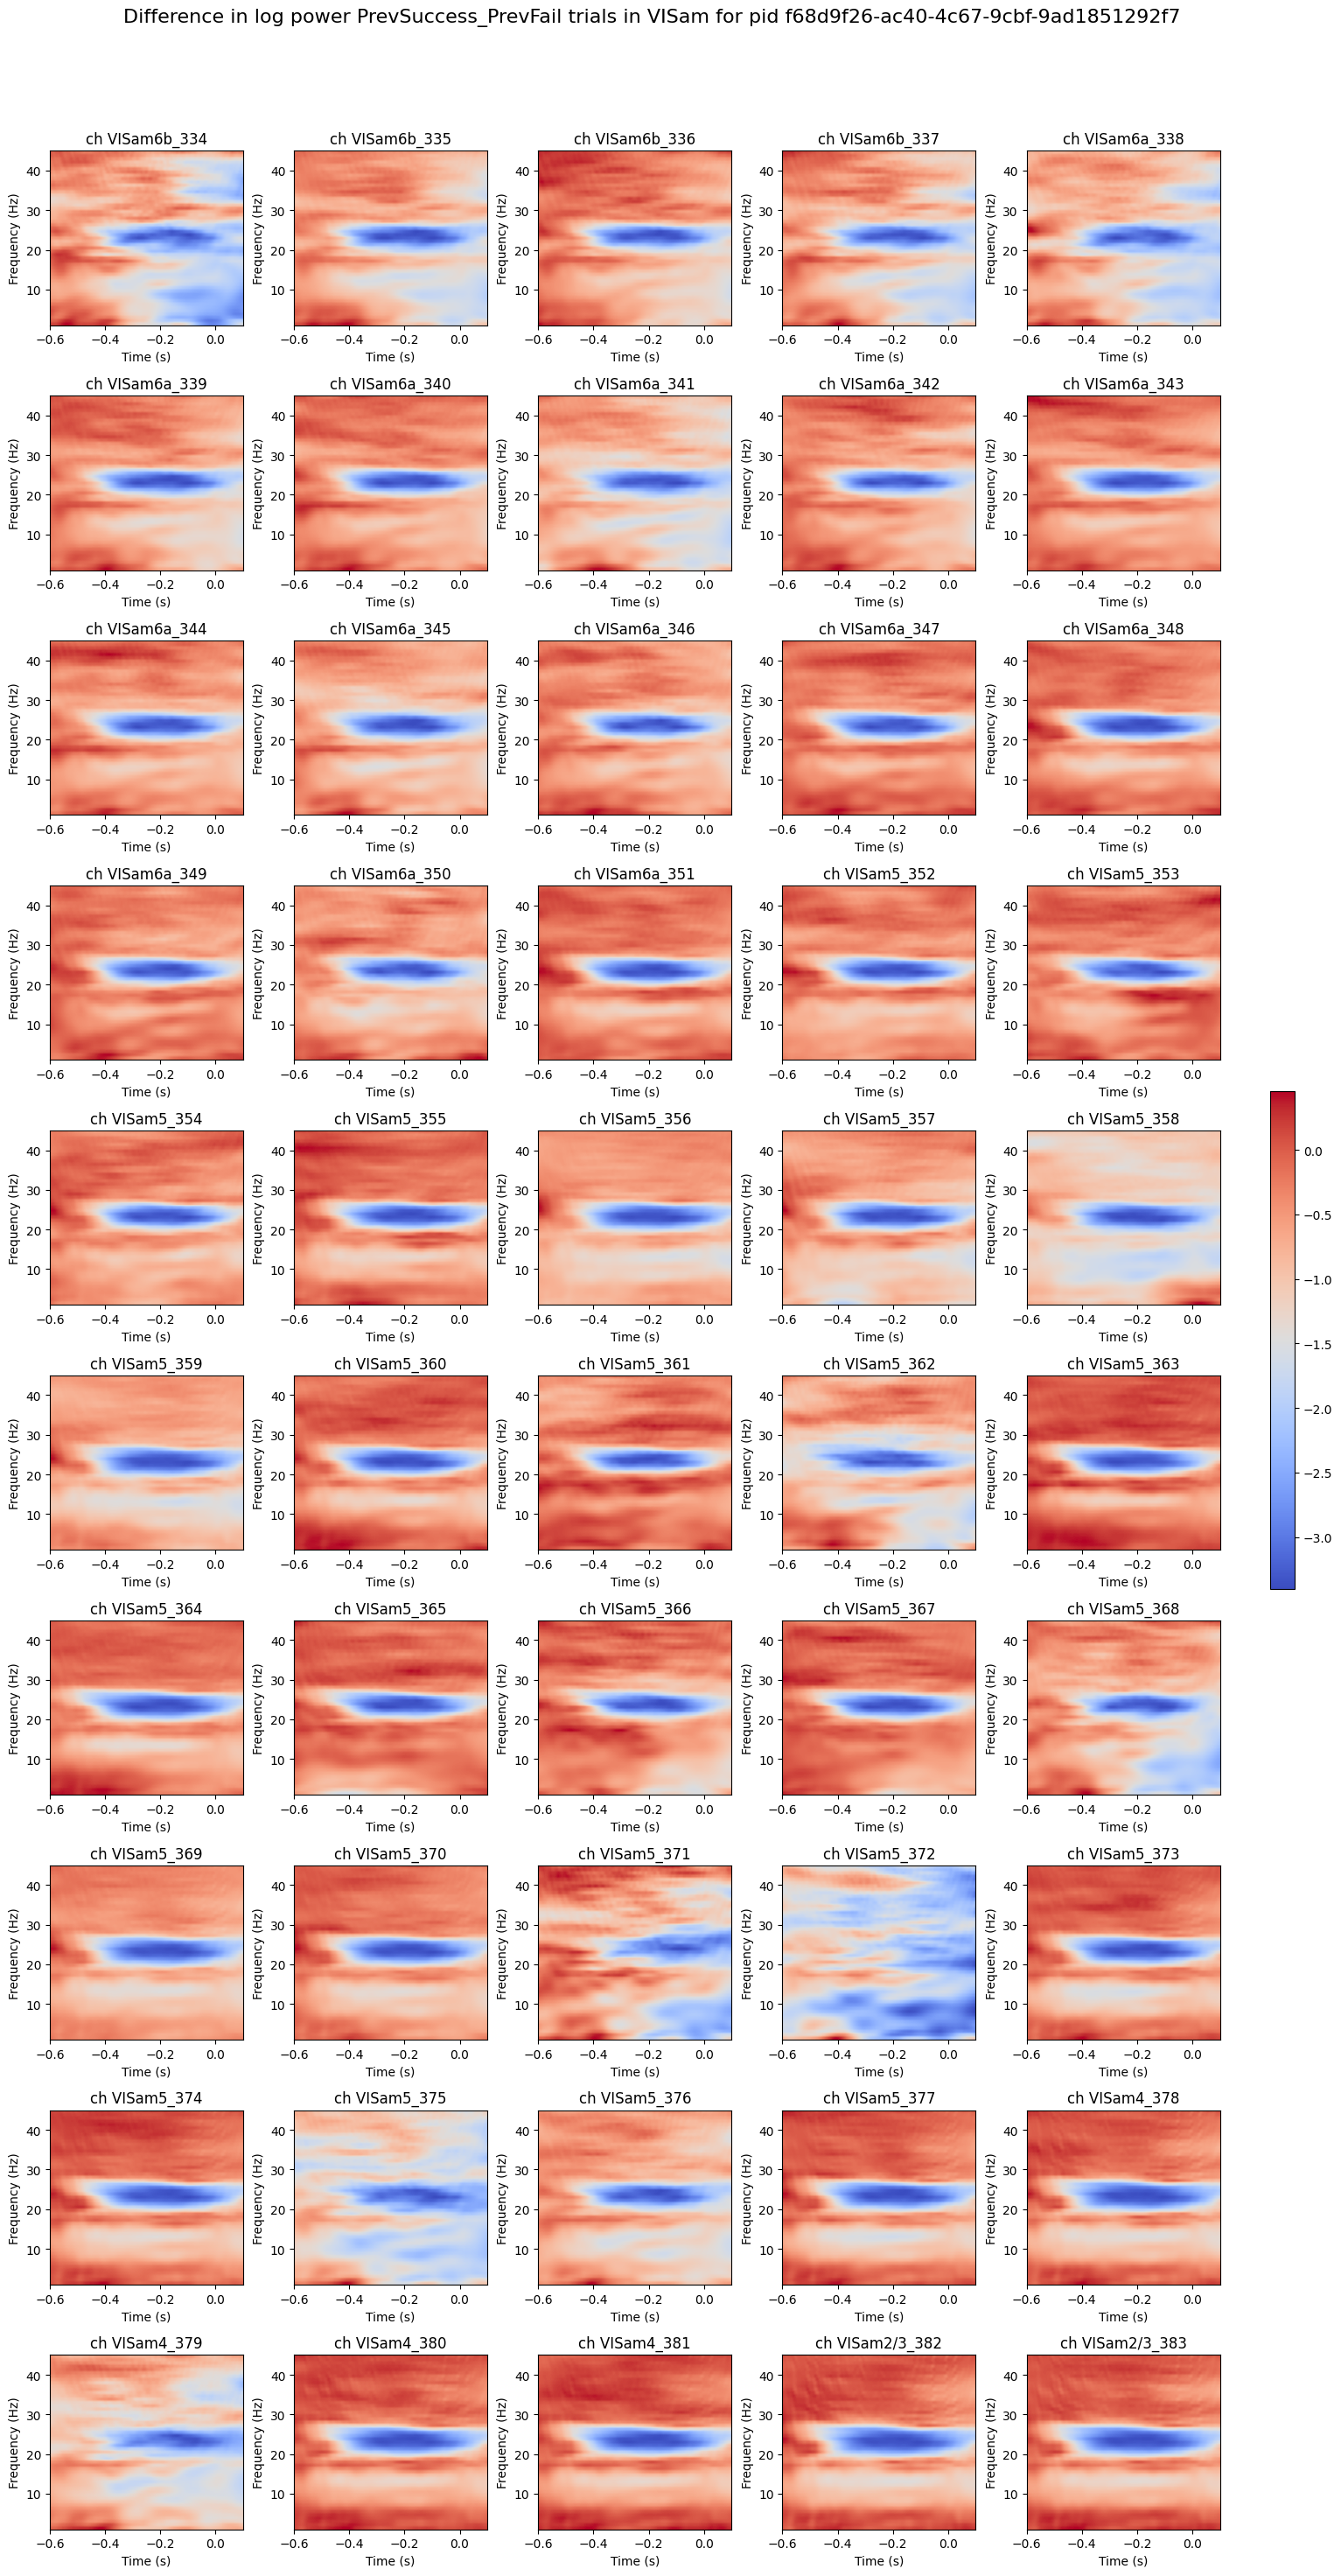

In [15]:
insersion = 5
pid = pids_to_plot[insersion-1]
print(f'Plotting for pid {pid}')
path = f'/mnt/data/AdaptiveControl/IBLrawdata/TF_data/{region}/TFR_{condition}_{pid}.npy'
diff = np.load(path)
raw = mne.io.read_raw_fif(f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_raw.fif', preload=True)
bad_channels = list(raw.info['bads'])
Visual_channels_clean = [ch for ch in raw.ch_names if isinstance(ch, str) and re.match(fr'^{region}[12456]', ch) and ch not in bad_channels]
del raw

global_vmax = np.max(diff)
global_vmin = np.min(diff)
channel = diff.shape[0]  # Number of channels


columns = 5
rows = int(np.ceil(channel / columns))

fig, axes = plt.subplots(rows, columns, figsize=(15, rows * 3), 
                         sharex=False, sharey=False)

fig.suptitle(f'Difference in log power {condition} trials in {region} for pid {pid}', fontsize=16)
# Flatten axes for easy iteration
axes = axes.flatten()

# Loop through each channel and plot the differences
for i, ax in enumerate(axes[:channel]):
    im = ax.imshow(diff[i], aspect='auto', origin='lower',
                   extent= [tmin, tmax, 1, 45],
                   cmap='coolwarm')
    ax.set_title(f'ch {Visual_channels_clean[i]}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')

# Remove any unused subplots if channels are less than the number of axes
for ax in axes[channel:]:
    fig.delaxes(ax)

# Adjust layout and add a colorbar
fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)

plt.show()